In [30]:
import pandas as pd
import numpy as np
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Initialize Faker to generate fake data
fake = Faker()

In [5]:
# Function to generate random customer data with age-based income
def generate_customer_data(num_samples=100000):
    data = []
    for _ in range(num_samples):
        # Generate random data for each customer
        customer_id = fake.uuid4()
        age = np.random.randint(18, 60)  # Age between 18 and 60
        
        # Income based on age (mapping age ranges to income ranges)
        if 18 <= age <= 25:
            annual_income = np.random.randint(120000, 200000)  # Early career
        elif 26 <= age <= 35:
            annual_income = np.random.randint(200000, 300000)  # Mid career
        elif 36 <= age <= 45:
            annual_income = np.random.randint(300000, 500000)  # Stable career
        elif 46 <= age <= 55:
            annual_income = np.random.randint(500000, 600000)  # Peak earning years
        else:
            annual_income = np.random.randint(400000, 600000)  # Decline or stable late career
        
        credit_score = np.random.randint(300, 850)  # Credit score between 300 and 850
        loan_amount = np.random.randint(5000, 400000)  # Loan amount between 10k and 100k
        interest_rate = np.random.uniform(2.5, 15.0)  # Interest rate between 2.5% and 15%
        loan_term = np.random.choice([15, 20, 30])  # Loan term in years (common terms: 15, 20, 30)
        repayment_status = np.random.choice([0, 1])  # 0 = No default, 1 = Default (target variable)
        
        data.append([customer_id, age, annual_income, credit_score, loan_amount, interest_rate, loan_term, repayment_status])
        # Create a DataFrame from the generated data
    df = pd.DataFrame(data, columns=['Customer_id', 'Age', 'Annual_income', 'Credit_score', 'Loan_amount', 'Interest_rate', 'Loan_term', 'Repayment_status'])
    
    # Generate additional features for feature engineering (Example: income-to-loan ratio)
    df['Income_to_loan_ratio'] = df['Annual_income'] / df['Loan_amount']
    
    return df


In [6]:
# Generate the data
df = generate_customer_data(100000)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Customer_id           100000 non-null  object 
 1   Age                   100000 non-null  int64  
 2   Annual_income         100000 non-null  int64  
 3   Credit_score          100000 non-null  int64  
 4   Loan_amount           100000 non-null  int64  
 5   Interest_rate         100000 non-null  float64
 6   Loan_term             100000 non-null  int64  
 7   Repayment_status      100000 non-null  int64  
 8   Income_to_loan_ratio  100000 non-null  float64
dtypes: float64(2), int64(6), object(1)
memory usage: 6.9+ MB


In [57]:
df.to_csv('bank_loan_data.csv', index=False)

In [58]:
df = pd.read_csv('bank_loan_data.csv')
df

,Customer_id,Age,Annual_income,Credit_score,Loan_amount,Interest_rate,Loan_term,Repayment_status,Income_to_loan_ratio,Monthly_income,Monthly_payment
0,45295824-57e4-42e7-b832-4d6a91dcdfc3,52,566745,802,257739,5.988229,30,1,2.198911,47228.750000,9271.801448
1,06e19acf-138f-4379-bc59-49e497b9f05c,44,445269,592,284378,9.314536,20,0,1.565765,37105.750000,15406.135231
2,108ea1e0-3d30-4ae6-ae70-8e83ea670f13,48,582272,605,179914,7.996184,30,1,3.236391,48522.666667,6636.411396
3,7ac09e80-993d-48a4-b0d6-bf752fefbda8,31,251158,787,297335,9.474059,15,0,0.844697,20929.833333,21097.287588
4,4e3653f5-69ca-4c53-bfc0-9834b959ad97,31,277308,599,91385,12.603303,15,0,3.034502,23109.000000,6616.697515
...,...,...,...,...,...,...,...,...,...,...,...
99995,993c6c2b-8d9a-4f8f-a188-bd35311eea20,33,217996,528,26529,6.158814,15,1,8.217272,18166.333333,1842.083835
99996,eb56acef-d5bf-426a-99e1-dffb5fbf81ce,48,584607,691,41579,14.128567,15,1,14.060151,48717.250000,3040.150102
99997,d0c36e8a-cc7d-481e-a153-76000cfd9694,49,582155,553,316759,10.935524,15,1,1.837848,48512.916667,22689.366437
99998,ff2c9d5e-0da2-435f-9fab-8f7847d4f2d6,52,578962,490,218945,2.687198,30,0,2.644326,48246.833333,7554.221929


In [8]:
# Feature Engineering: Derived Attributes
# 1. Monthly income

df["Monthly_income"] = df["Annual_income"] / 12

# 2. Payment per Month (using loan amount, interest rate, and loan term)
def calculate_monthly_payment(principal, annual_interest_rate, term_months):
    monthly_interest_rate = annual_interest_rate / 100 / 12
    return (principal * monthly_interest_rate) / (1 - (1 + monthly_interest_rate) ** -term_months)

df["Monthly_payment"] = df.apply(lambda x: calculate_monthly_payment(x["Loan_amount"], x["Interest_rate"], x["Loan_term"]), axis=1)

In [9]:
df.head()

,Customer_id,Age,Annual_income,Credit_score,Loan_amount,Interest_rate,Loan_term,Repayment_status,Income_to_loan_ratio,Monthly_income,Monthly_payment
0,45295824-57e4-42e7-b832-4d6a91dcdfc3,52,566745,802,257739,5.988229,30,1,2.198911,47228.750000,9271.801448
1,06e19acf-138f-4379-bc59-49e497b9f05c,44,445269,592,284378,9.314536,20,0,1.565765,37105.750000,15406.135231
2,108ea1e0-3d30-4ae6-ae70-8e83ea670f13,48,582272,605,179914,7.996184,30,1,3.236391,48522.666667,6636.411396
3,7ac09e80-993d-48a4-b0d6-bf752fefbda8,31,251158,787,297335,9.474059,15,0,0.844697,20929.833333,21097.287588
4,4e3653f5-69ca-4c53-bfc0-9834b959ad97,31,277308,599,91385,12.603303,15,0,3.034502,23109.000000,6616.697515


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Customer_id           100000 non-null  object 
 1   Age                   100000 non-null  int64  
 2   Annual_income         100000 non-null  int64  
 3   Credit_score          100000 non-null  int64  
 4   Loan_amount           100000 non-null  int64  
 5   Interest_rate         100000 non-null  float64
 6   Loan_term             100000 non-null  int64  
 7   Repayment_status      100000 non-null  int64  
 8   Income_to_loan_ratio  100000 non-null  float64
 9   Monthly_income        100000 non-null  float64
 10  Monthly_payment       100000 non-null  float64
dtypes: float64(4), int64(6), object(1)
memory usage: 8.4+ MB


In [11]:
df.describe()

,Age,Annual_income,Credit_score,Loan_amount,Interest_rate,Loan_term,Repayment_status,Income_to_loan_ratio,Monthly_income,Monthly_payment
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,38.512320,363778.675280,574.786530,202590.507050,8.724571,21.65420,0.502610,4.031764,30314.889607,10927.781570
std,12.118984,151536.452784,158.749474,114067.482616,3.612864,6.23839,0.499996,7.787777,12628.037732,6936.159445
min,18.000000,120003.000000,300.000000,5000.000000,2.500139,15.00000,0.000000,0.301953,10000.250000,177.429182
25%,28.000000,225369.250000,437.000000,104046.500000,5.587127,15.00000,0.000000,1.087623,18780.770833,5239.529735
50%,39.000000,359095.500000,575.000000,202519.000000,8.730200,20.00000,1.000000,1.789785,29924.625000,10167.570861
75%,49.000000,512965.250000,712.000000,301437.000000,11.852336,30.00000,1.000000,3.504966,42747.104167,15431.008083
max,59.000000,599999.000000,849.000000,399991.000000,14.999901,30.00000,1.000000,115.207400,49999.916667,29351.863826


In [12]:
df.isnull().sum()

Customer_id             0
Age                     0
Annual_income           0
Credit_score            0
Loan_amount             0
Interest_rate           0
Loan_term               0
Repayment_status        0
Income_to_loan_ratio    0
Monthly_income          0
Monthly_payment         0
dtype: int64

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df["Repayment_status"].value_counts()

Repayment_status
1    50261
0    49739
Name: count, dtype: int64

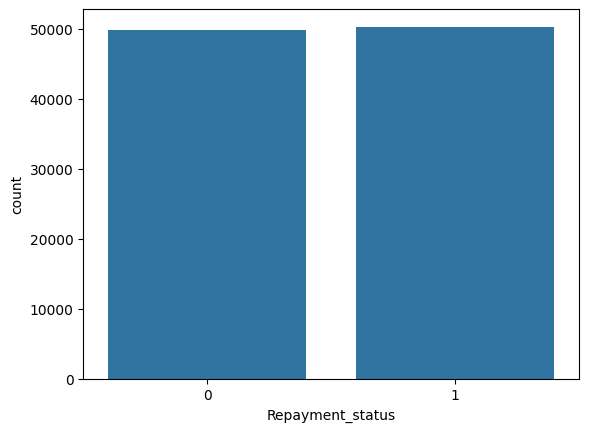

In [17]:
# Plot distribution of repayment_status
sns.countplot(x="Repayment_status", data=df)
plt.show()

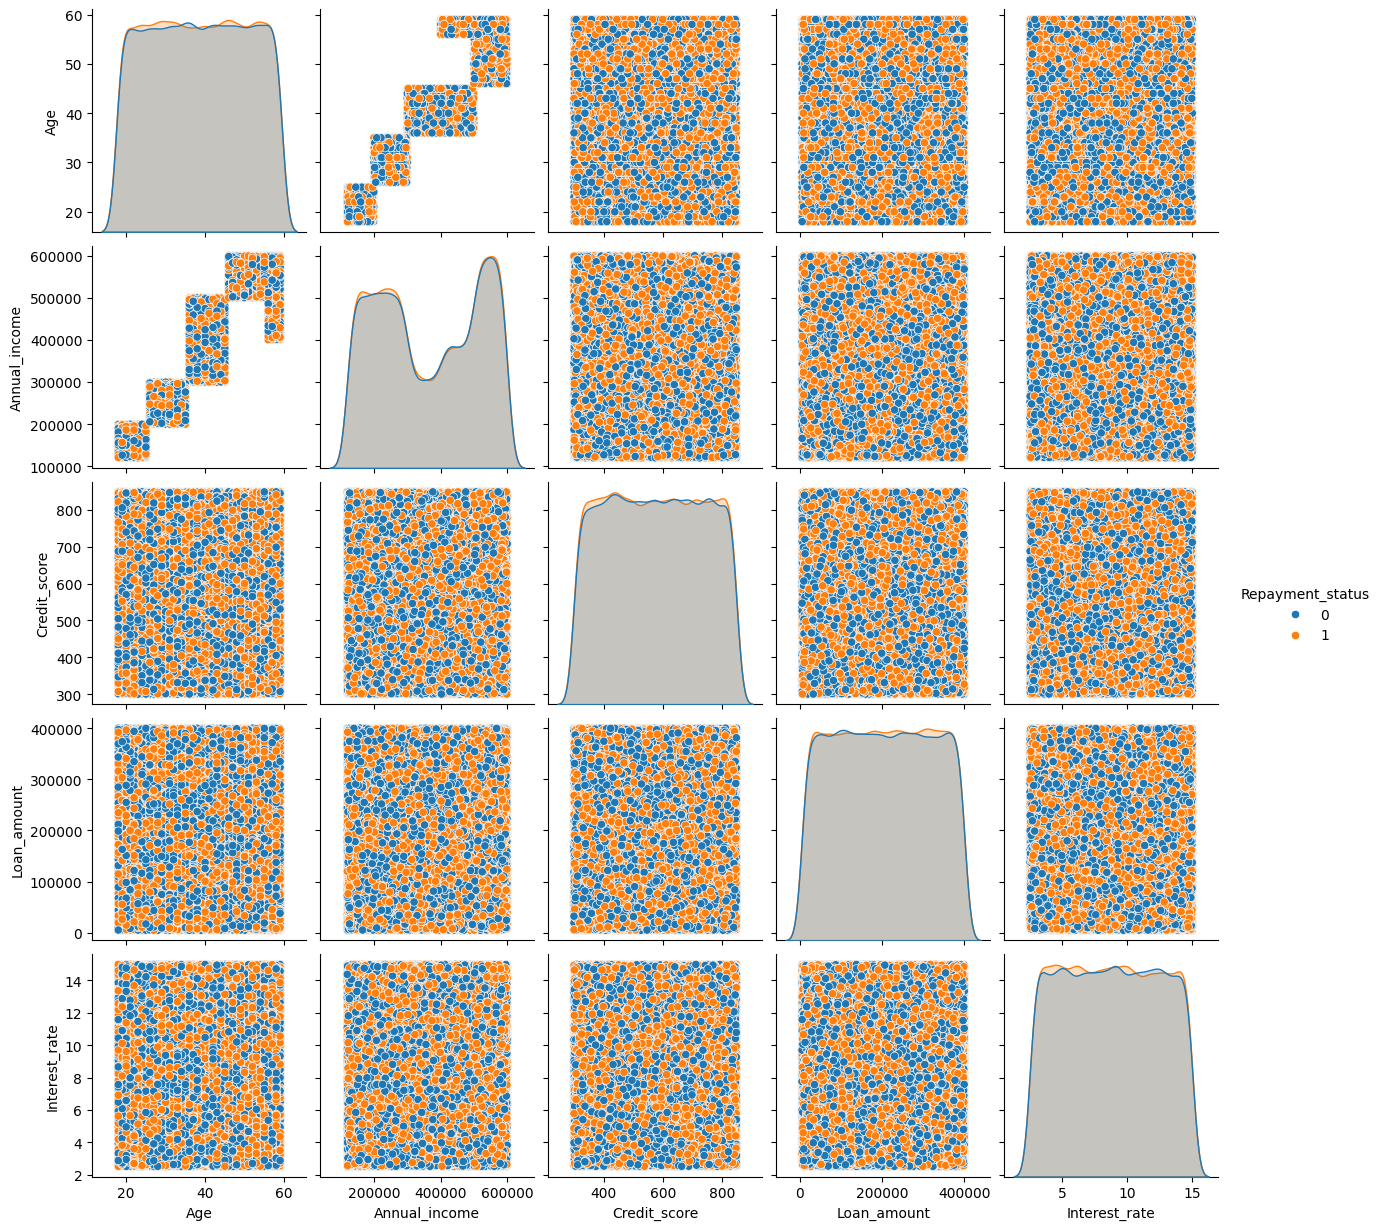

In [18]:
# Pairplot for key features
sns.pairplot(df, vars=["Age", "Annual_income", "Credit_score", "Loan_amount", "Interest_rate"], hue="Repayment_status")
plt.show()

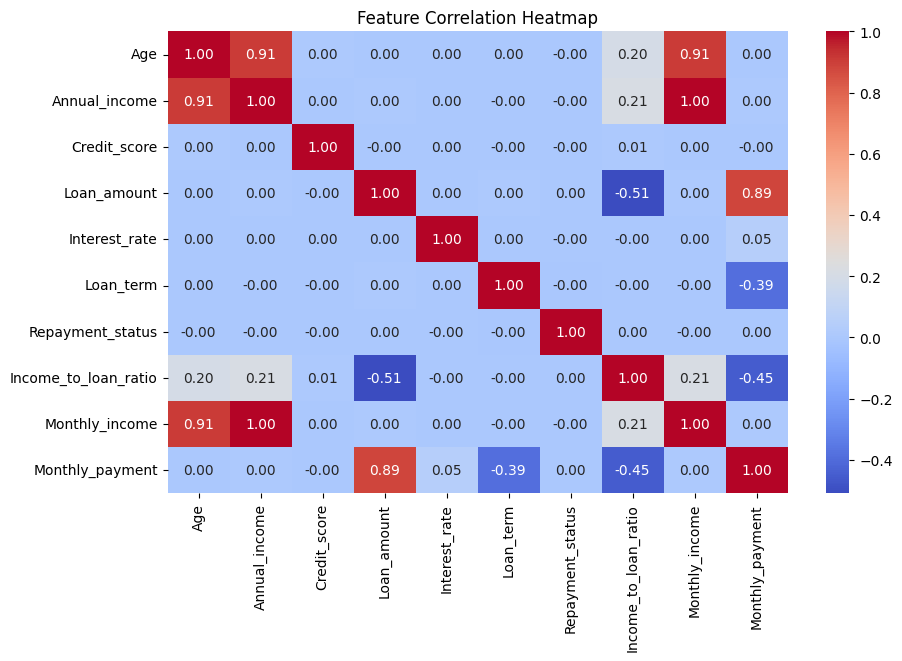

In [19]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=['Customer_id']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

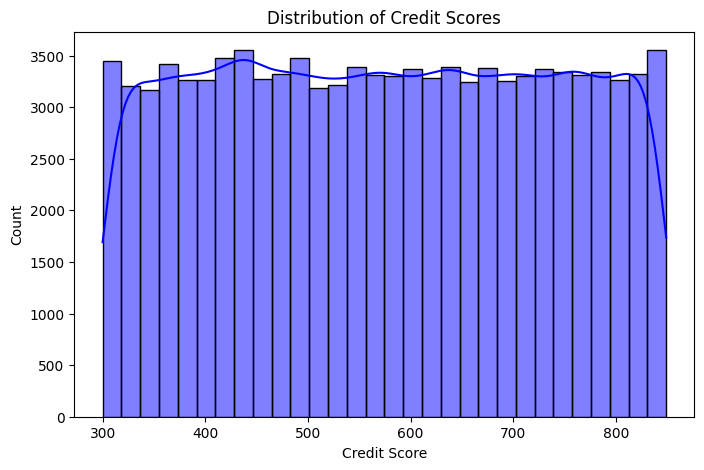

In [20]:
# Distribution of Credit Scores
plt.figure(figsize=(8, 5))
sns.histplot(df["Credit_score"], bins=30, kde=True, color="blue")
plt.title("Distribution of Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Count")
plt.show()

C:\Users\Merlin\AppData\Local\Temp\ipykernel_15536\3523259579.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Repayment_status"], y=df["Annual_income"], palette=["green", "red"])


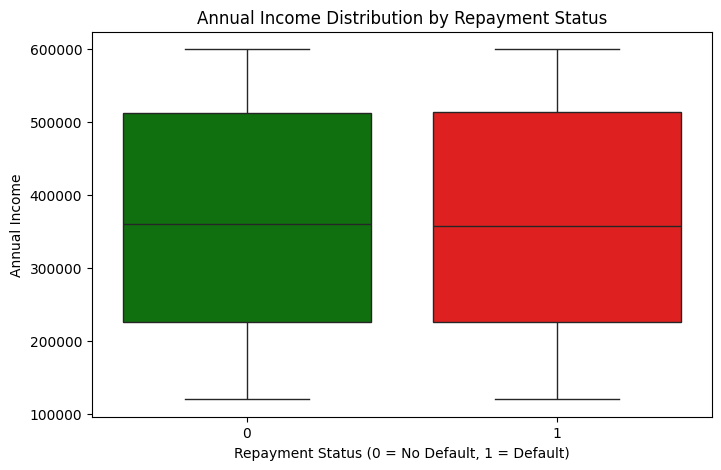

In [21]:
# Boxplot of Annual Income by Repayment Status
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Repayment_status"], y=df["Annual_income"], palette=["green", "red"])
plt.title("Annual Income Distribution by Repayment Status")
plt.xlabel("Repayment Status (0 = No Default, 1 = Default)")
plt.ylabel("Annual Income")
plt.show()

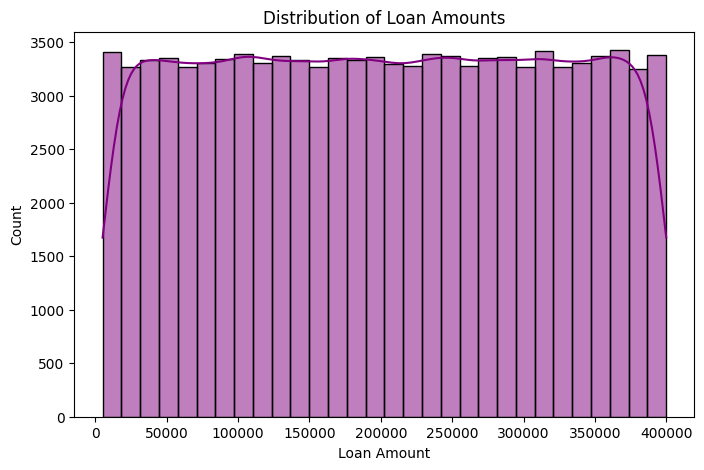

In [22]:
# Loan Amount Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Loan_amount"], bins=30, kde=True, color="purple")
plt.title("Distribution of Loan Amounts")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

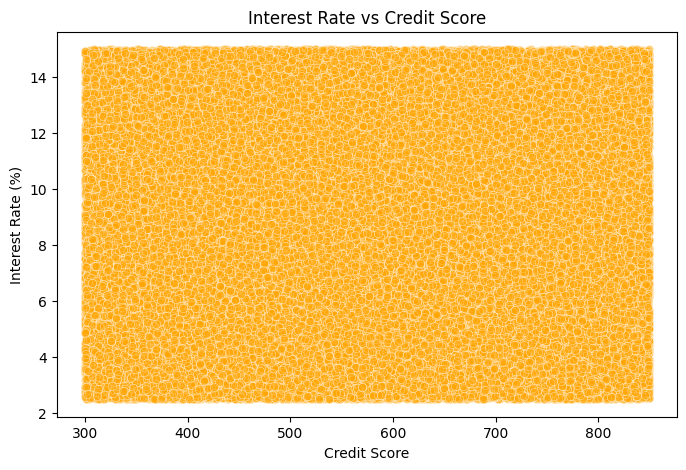

In [23]:
# Interest Rate vs Credit Score
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Credit_score"], y=df["Interest_rate"], alpha=0.5, color="orange")
plt.title("Interest Rate vs Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Interest Rate (%)")
plt.show()

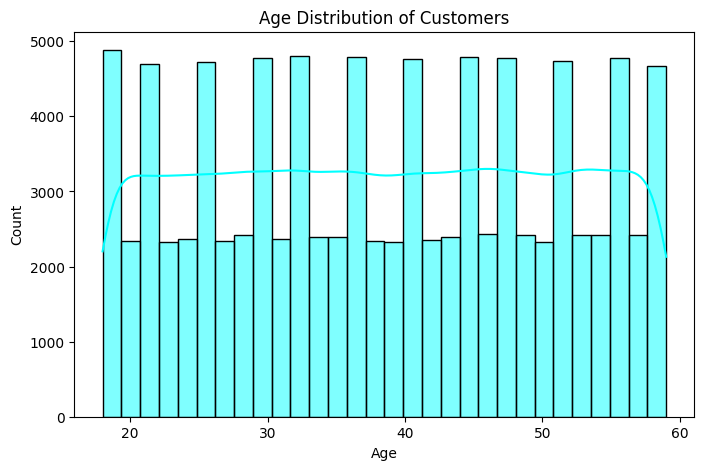

In [24]:
# Age Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Age"], bins=30, kde=True, color="cyan")
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [26]:
X = df.drop(columns=["Customer_id","Repayment_status"])
Y = df["Repayment_status"]


In [27]:
X.shape, Y.shape

((100000, 9), (100000,))

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled,Y, test_size=0.2, random_state=42)

In [33]:
# Ridge (L2) Regularization
ridge_model = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')
ridge_model.fit(X_train, Y_train)
y_pred_ridge = ridge_model.predict(X_test)

In [34]:
# Lasso (L1) Regularization
lasso_model = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
lasso_model.fit(X_train, Y_train)
y_pred_lasso = lasso_model.predict(X_test)

In [35]:
# Evaluate both models
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
    print("-" * 30)

evaluate_model(Y_test, y_pred_ridge, "Ridge (L2) Logistic Regression")
evaluate_model(Y_test, y_pred_lasso, "Lasso (L1) Logistic Regression")

--- Ridge (L2) Logistic Regression ---
Accuracy: 0.50
Precision: 0.50
Recall: 0.74
F1 Score: 0.60
------------------------------
--- Lasso (L1) Logistic Regression ---
Accuracy: 0.50
Precision: 0.50
Recall: 0.75
F1 Score: 0.60
------------------------------


In [36]:
model = LogisticRegression()
model.fit(X_train,Y_train)

LogisticRegression()

In [37]:
X_pred=model.predict(X_train)

In [38]:
accuracy = accuracy_score(Y_train, X_pred)
precision = precision_score(Y_train, X_pred)
recall = recall_score(Y_train, X_pred)
f1 = f1_score(Y_train, X_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.50
Precision: 0.50
Recall: 0.74
F1 Score: 0.60


In [39]:
y_pred = model.predict(X_test)

In [40]:
# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.50
Precision: 0.50
Recall: 0.74
F1 Score: 0.60


In [41]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest with max_depth=3
rf_model_3 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model_3.fit(X_train, Y_train)


RandomForestClassifier(max_depth=3, random_state=42)

In [42]:
y_pred_rf_3 = rf_model_3.predict(X_test)

In [43]:
# Random Forest with max_depth=4
rf_model_4 = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf_model_4.fit(X_train, Y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [44]:
y_pred_rf_4 = rf_model_4.predict(X_test)

In [45]:
# Function to evaluate model
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
    print("-" * 30)

# Evaluate models
evaluate_model(Y_test, y_pred_rf_3, "Random Forest (max_depth=3)")
evaluate_model(Y_test, y_pred_rf_4, "Random Forest (max_depth=4)")


--- Random Forest (max_depth=3) ---
Accuracy: 0.51
Precision: 0.51
Recall: 0.86
F1 Score: 0.64
------------------------------
--- Random Forest (max_depth=4) ---
Accuracy: 0.50
Precision: 0.50
Recall: 0.78
F1 Score: 0.61
------------------------------


In [53]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [54]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1,scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [55]:
# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [56]:
# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred_best)
precision = precision_score(Y_test, y_pred_best)
recall = recall_score(Y_test, y_pred_best)
f1 = f1_score(Y_test, y_pred_best)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.51
Precision: 0.51
Recall: 0.52
F1 Score: 0.52


In [46]:
from sklearn.ensemble import GradientBoostingClassifier

In [47]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train,Y_train)

GradientBoostingClassifier()

In [48]:
gb_x_pred=gb_model.predict(X_train)

In [49]:
accuracy = accuracy_score(Y_train, gb_x_pred)
precision = precision_score(Y_train, gb_x_pred)
recall = recall_score(Y_train, gb_x_pred)
f1 = f1_score(Y_train, gb_x_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.54
Precision: 0.53
Recall: 0.66
F1 Score: 0.59


In [51]:
gb_y_pred = gb_model.predict(X_test)

In [52]:
# Evaluate the model
accuracy = accuracy_score(Y_test, gb_y_pred)
precision = precision_score(Y_test, gb_y_pred)
recall = recall_score(Y_test, gb_y_pred)
f1 = f1_score(Y_test, gb_y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.50
Precision: 0.50
Recall: 0.62
F1 Score: 0.55


In [59]:
import joblib

# Save the trained Random Forest model
joblib.dump(rf_model_3, 'loan_default_model.pkl')
print("Model saved successfully!")


Model saved successfully!
